# 1: Hierarchical Customer Segmentation Analysis

This Jupyter notebook is dedicated to the exploration and analysis of customer data. The main goal is to conduct customer segmentation based on purchasing behavior. Customer segmentation is the process of dividing customers into groups based on common characteristics so companies can market to each group effectively and appropriately. Among the myriad ways of segmenting a customer base, hierarchical methods are widely used in practice due to their intuitive nature and their ease of interpretation. The notebook presents a hierarchical clustering approach to customer segmentation, which enables the uncovering of customer groups based on similarities in their purchasing patterns.

The notebook uses some important Python libraries such as `pandas` for data manipulation, `numpy` for numerical computations, and `matplotlib` for visualization. Additionally, it uses the `scipy.cluster.hierarchy` library for implementing hierarchical clustering.

As we work through this notebook, we'll gain insights into our customer's behaviors and implement data-driven strategies designed to better meet their needs. The insights derived could be useful in many business areas such as strategy planning, marketing, sales, and customer service.

To get the most out of this notebook, follow along with the code and try to experiment with the models and tweak their parameters.

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

## Load and Visualize Dataset

In [2]:
df = pd.read_csv(
    'raw_orders.txt',
    header=None,sep='\t',
    parse_dates=[2],
    names=['customer_id','purchase_amount','date_of_purchase'])
df['year_of_purchase'] = df.date_of_purchase.dt.year
df.head(5)

,customer_id,purchase_amount,date_of_purchase,year_of_purchase
0,760,25.0,2009-11-06,2009
1,860,50.0,2012-09-28,2012
2,1200,100.0,2005-10-25,2005
3,1420,50.0,2009-07-09,2009
4,1940,70.0,2013-01-25,2013


### Summarize Purchase Amounts by Years

In [18]:
dfg = pd.pivot_table(
    df,
    index='year_of_purchase',
    values=['purchase_amount'],
    aggfunc={'purchase_amount' :[np.size, np.average, np.sum]})
dfg = dfg['purchase_amount'].rename(columns={'size':'counter','average':'avg_amount','sum' : 'sum_amount'})
dfg

,counter,avg_amount,sum_amount
year_of_purchase,,,
2005,1470.0,55.826122,82064.40
2006,2182.0,52.250454,114010.49
2007,4674.0,49.264014,230260.00
2008,4331.0,53.071780,229853.88
2009,5054.0,50.745253,256466.51
2010,4939.0,58.740012,290116.92
2011,4785.0,63.519300,303939.85
2012,5960.0,62.913312,374963.34
2013,5912.0,67.931357,401610.18


<IPython.core.display.Javascript object>


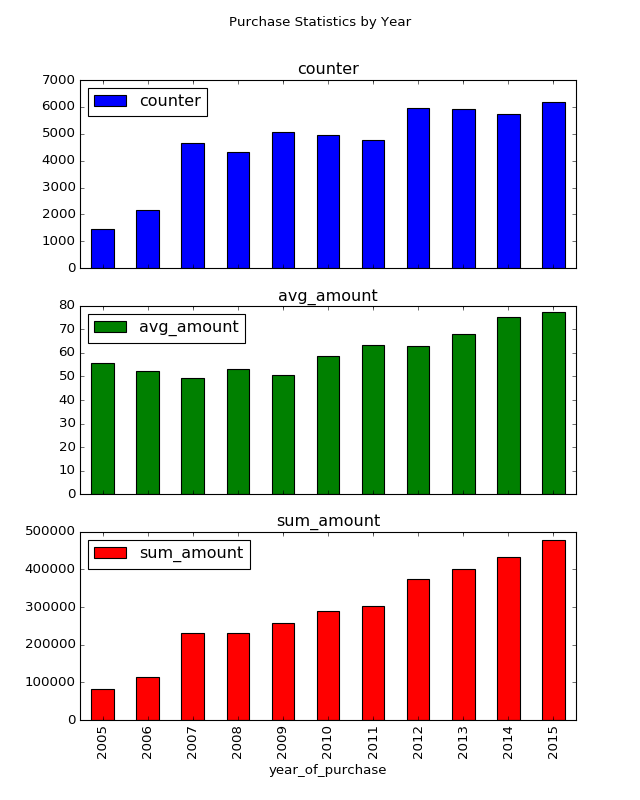

array([<matplotlib.axes._subplots.AxesSubplot object at 0x114095da0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x114cbce80>], dtype=object)

In [5]:
dfg.plot(kind='bar',subplots=True,figsize=(8,10),title='Purchase Statistics by Year')

## RFM Segmentation

### Recency Frequency Money Calculations

In [6]:
df['days_since'] = (df.date_of_purchase.max() - df.date_of_purchase).dt.days + 1
df.days_since.describe()

count    51243.000000
mean      1631.939309
std       1061.076889
min          1.000000
25%        733.000000
50%       1500.000000
75%       2540.000000
max       4016.000000
Name: days_since, dtype: float64

In [7]:
g = df.groupby(by='customer_id')
dfg = pd.DataFrame({
        'recency' : g.days_since.min(), 
        'frequency' : g.days_since.count(), 
        'amount' : g.purchase_amount.mean()})
dfg = dfg[['recency','frequency','amount']]
dfg.head()

,recency,frequency,amount
customer_id,,,
10,3829,1,30.000000
80,343,7,71.428571
90,758,10,115.800000
120,1401,1,20.000000
130,2970,2,50.000000


In [8]:
dfg.describe()

,recency,frequency,amount
count,18417.000000,18417.000000,18417.000000
mean,1253.037900,2.782375,57.792985
std,1081.437868,2.936888,154.360109
min,1.000000,1.000000,5.000000
25%,244.000000,1.000000,21.666667
50%,1070.000000,2.000000,30.000000
75%,2130.000000,3.000000,50.000000
max,4014.000000,45.000000,4500.000000


<IPython.core.display.Javascript object>


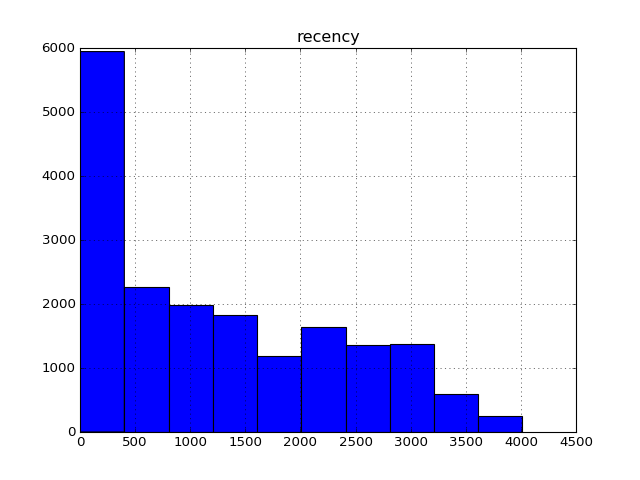

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117139c50>]], dtype=object)

In [9]:
dfg.hist('recency')

<IPython.core.display.Javascript object>


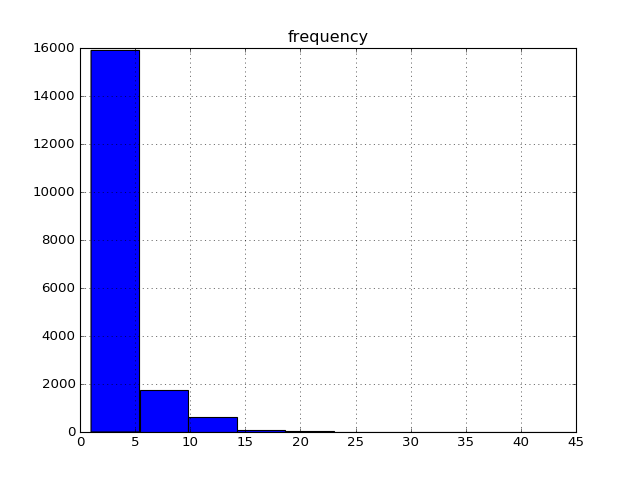

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1172d27b8>]], dtype=object)

In [10]:
dfg.hist('frequency')

<IPython.core.display.Javascript object>


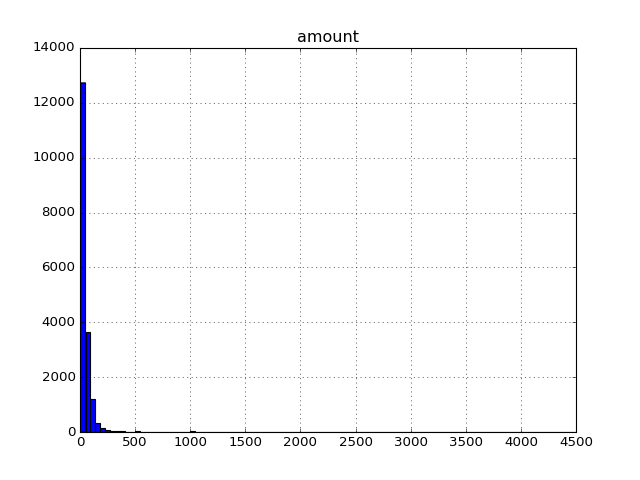

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117349390>]], dtype=object)

In [11]:
dfg.hist(column='amount',bins=100)


### Standard Scaling and Dispersion Adjustments

In [12]:
scaler = StandardScaler()
X = dfg.copy()
X['amount'] = np.log(X.amount)
X_scaled = pd.DataFrame(scaler.fit_transform(X),columns=X.columns,index=dfg.index)
X_scaled.describe()

,recency,frequency,amount
count,1.841700e+04,1.841700e+04,1.841700e+04
mean,-5.341850e-15,2.472511e-15,-1.983777e-15
std,1.000027e+00,1.000027e+00,1.000027e+00
min,-1.157784e+00,-6.069088e-01,-2.570124e+00
25%,-9.330775e-01,-6.069088e-01,-6.597654e-01
50%,-1.692588e-01,-2.664031e-01,-2.358019e-01
75%,8.109443e-01,7.410256e-02,4.297068e-01
max,2.553117e+00,1.437534e+01,6.292104e+00


### Use Subsample of Dataset For Hierarchical Clusters

In [13]:
# sample = resample(X_scaled.index,replace=False,n_samples=np.int(X_scaled.index.size/10),random_state=10)
sample = X_scaled.index[np.arange(0,X_scaled.index.size,10)]
X_sample = X.loc[sample].copy()
X_sample.describe()

,recency,frequency,amount
count,1842.000000,1842.000000,1842.000000
mean,1260.163952,2.804560,3.566935
std,1085.954407,2.943026,0.749310
min,1.000000,1.000000,1.609438
25%,239.000000,1.000000,3.075775
50%,1096.000000,2.000000,3.401197
75%,2123.000000,3.000000,3.912023
max,3908.000000,28.000000,7.703137


In [14]:
X_scaled_sample = X_scaled.loc[sample].copy()
X_scaled_sample.describe()

,recency,frequency,amount
count,1842.000000,1842.000000,1842.000000
mean,0.006590,0.007554,-0.019878
std,1.004204,1.002117,0.976208
min,-1.157784,-0.606909,-2.570124
25%,-0.937701,-0.606909,-0.659765
50%,-0.145216,-0.266403,-0.235802
75%,0.804471,0.074103,0.429707
max,2.455096,8.586745,5.368807


### Hierarchical Cluster

<IPython.core.display.Javascript object>


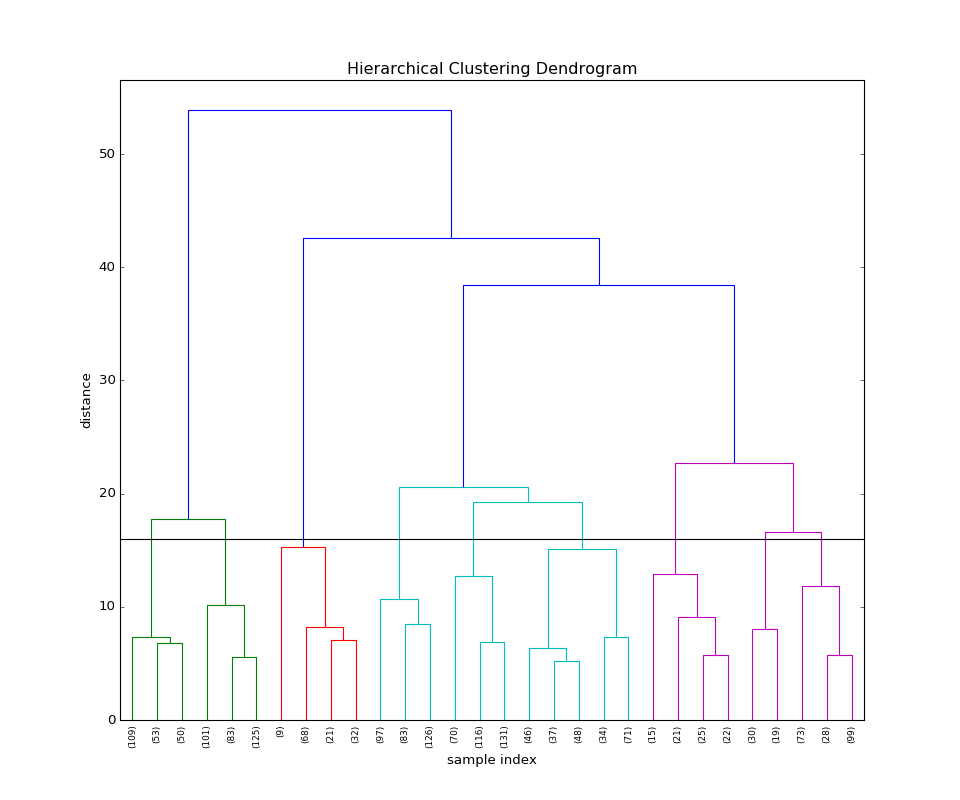

In [15]:
# https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
Z = linkage(X_scaled_sample,'ward')

# calculate full dendrogram
plt.figure(figsize=(12, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',
    p=30,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.axhline(y=16,c='k')
plt.show()

### Choose Nine Clusters

In [16]:
k=9
members = fcluster(Z, k, criterion='maxclust')
X_sample = dfg.loc[sample]
X_sample['cluster'] = members
X_cluster = pd.pivot_table(X_sample,index=['cluster'],aggfunc=[np.mean])
X_cluster['count'] = X_sample.groupby(by='cluster').amount.size()
X_cluster[['count','mean']]

count        mean                        
                   amount  frequency      recency
cluster                                          
1         212   16.263365   1.311321  2684.292453
2         309   37.784736   1.284790  2563.236246
3         130   42.015211  10.615385   193.646154
4         306   41.106405   2.398693   162.104575
5         317   22.433570   1.280757   922.829653
6         236   29.854206   4.466102  1143.694915
7          83  261.219139   6.578313   448.578313
8          49  214.861973   1.857143  2567.040816
9         200   87.429167   1.400000   799.340000

### Plot Averages For Each Cluster

<IPython.core.display.Javascript object>


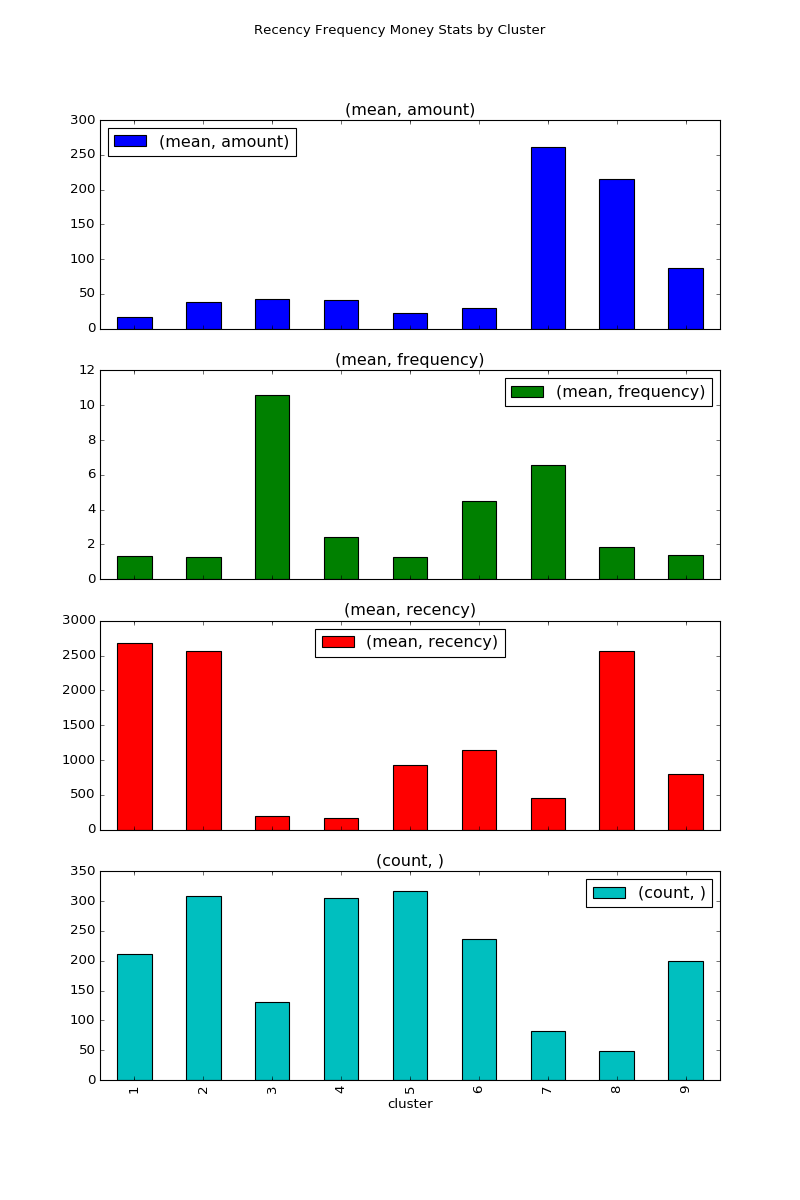

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1193a2d30>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x1197617b8>], dtype=object)

In [17]:
X_cluster.plot.bar(subplots=True,title='Recency Frequency Money Stats by Cluster',figsize=(10,15))